In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
ls

01_data_cleaning.ipynb    data_visualisation.ipynb
cleaned_bmw_data.csv      model_prediction.ipynb


In [3]:
df = pd.read_csv('cleaned_bmw_data.csv')

In [4]:
# --- Load and Engineer Features ---
df = pd.read_csv('cleaned_bmw_data.csv')
df['car_age'] = 2025 - df['year']
df.drop('year', axis=1, inplace=True)
# Drop model column for simplicity
df_model = df.drop('model', axis=1)

In [5]:
# --- Variable Encoding ---
# One-hot encode the remaining categorical features
df_model = pd.get_dummies(df_model, columns=['transmission', 'fuelType'], drop_first=True)

In [6]:
# --- Define Features (X) and Target (y) ---
X = df_model.drop('price', axis=1)
y = df_model['price']

# --- Split Data into Training and Testing Sets ---
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data has been prepared and split for modeling.")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Data has been prepared and split for modeling.
Training set shape: (6899, 11)
Testing set shape: (1725, 11)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


In [8]:
# --- Define the Hyperparameter Grid ---
# We'll search over a range of values for key parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 1.0] # Use 1.0 for all features (equivalent to former 'auto')
}

In [9]:
# --- Set up and Run Randomized Search ---
# Initialize the model
rf = RandomForestRegressor(random_state=42)

In [10]:
# n_iter=50 means it will try 50 different combinations
# cv=5 means 5-fold cross-validation
rf_random_search = RandomizedSearchCV(estimator=rf,
                                      param_distributions=param_grid,
                                      n_iter=50,
                                      cv=5,
                                      verbose=2,
                                      random_state=42,
                                      n_jobs=-1) # Use all available cores

# Fit the search to find the best model
rf_random_search.fit(X_train, y_train)

# --- Get the Best Model ---
best_rf_model = rf_random_search.best_estimator_
print(f"\\nBest Hyperparameters found: {rf_random_search.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
\nBest Hyperparameters found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None}


--- Tuned Random Forest Model Performance ---
R-squared (R²): 0.857
Mean Absolute Error (MAE): £2646.91
Root Mean Squared Error (RMSE): £4311.02


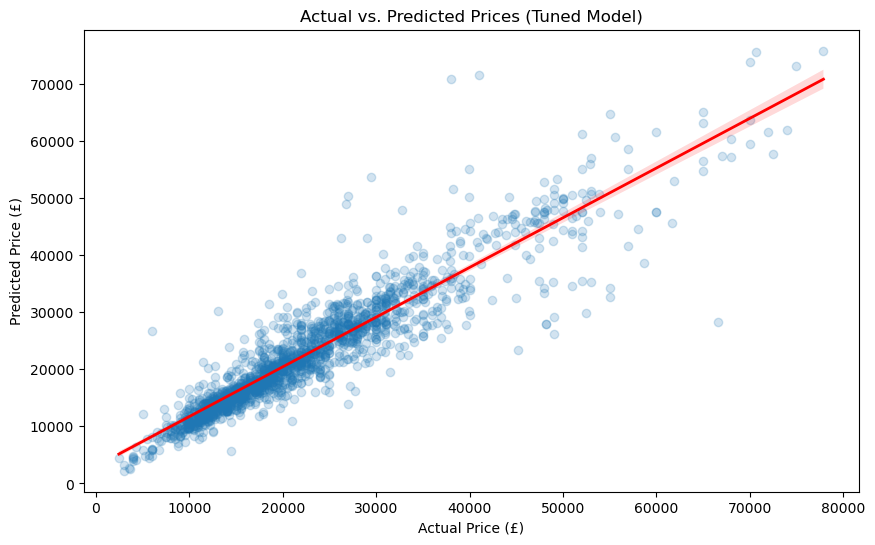

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns

# Make predictions with the best model
y_pred = best_rf_model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the results
print("--- Tuned Random Forest Model Performance ---")
print(f"R-squared (R²): {r2:.3f}")
print(f"Mean Absolute Error (MAE): £{mae:.2f}")
print(f"Root Mean Squared Error (RMSE): £{rmse:.2f}")

# Visualize the actual vs. predicted prices
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.2}, line_kws={'color':'red', 'linewidth':2})
plt.title('Actual vs. Predicted Prices (Tuned Model)')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.show()